# Part 3: Exploratory Data Analysis (EDA) & Static Network Snapshot Analysis (Year 2023)

**Objective:** This notebook performs a detailed exploratory data analysis and a static network analysis for the year 2023 using the `trade_data.csv` file from Part 1. It aims to:
1.  **Load and Filter Data:** Isolate the 2023 data from the full dataset, resulting in **460** trade-pair observations for analysis.
2.  **Perform General EDA:** Identify the top importers (USA, Mexico, Canada) and exporters (China, USA, Mexico) by trade volume for 2023.
3.  **Construct a Static Graph:** Build a directed, weighted trade graph for 2023, comprising **79 nodes** (countries) and **460 edges** (trade flows).
4.  **Analyze Network Properties:** Calculate key metrics, finding a network density of **0.0747** and an average clustering coefficient of **0.2934**.
5.  **Identify Important Countries:** Compute centrality measures (PageRank, HITS, etc.), with **Greedy Modularity** emerging as the best community detection method (Modularity: **0.1094**).
6.  **Detect and Compare Communities:** Use multiple algorithms (Louvain, Spectral Clustering, etc.) and compare results against a ground truth of real-world trade blocs.
7.  **Visualize Network:** Create world map visualizations for the overall network structure, centrality scores, and detected communities.
8.  **Perform Advanced Structural Analysis:** Identify a maximum k-core of **12** and find **227 maximal cliques** of size 4 or more, revealing densely connected trade groups.
9.  **Analyze Degree Distributions:** Examine the network for power-law characteristics and calculate assortativity.
10. **Compare to Standard Models:** Benchmark the real network's properties against standard Erdos-Renyi (ER), Barabási-Albert (BA), and Watts-Strogatz (WS) models.

## 1. Setup and Configuration

In [45]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors # For some specific color handling if needed
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import sqrt
import community as community_louvain # For Louvain algorithm (python-louvain)
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import MinMaxScaler
import powerlaw # Optional: for power-law fitting
import warnings
from IPython.display import display, HTML

# Configuration
STATIC_ANALYSIS_YEAR = 2023
INPUT_DATA_FILE = 'trade_data.csv' # Output from Part 1
TOP_N_CENTRALITY = 10
MIN_CLIQUE_SIZE_FILTER = 4 # Min size for displaying cliques

# Plotting preferences
plt.style.use('seaborn-v0_8-whitegrid') 
plt.rcParams.update({'font.size': 10, 'figure.figsize': (14, 9)})
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='cartopy')
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='powerlaw') # For sparse data in powerlaw

## 2. Load Data and Prepare 2023 Snapshot
The full, multi-year dataset (`trade_data.csv`) is loaded, containing 17,170 records across years 1988-2024. The data is then filtered to create a snapshot for the `STATIC_ANALYSIS_YEAR` (2023). This snapshot initially contains 460 records. Any rows with missing latitude, longitude, or trade amount values are dropped to ensure a clean dataset for graph construction, which results in a final snapshot of 460 rows and 8 columns.

In [46]:
try:
    df_multi_year = pd.read_csv(INPUT_DATA_FILE)
except FileNotFoundError:
    print(f"Error: {INPUT_DATA_FILE} not found. Please ensure it's in the correct directory.")
    raise # Stop execution if data is missing

print(f"Full dataset loaded. Shape: {df_multi_year.shape}")
print(f"Years available: {sorted(df_multi_year['year'].unique())}")

df_2023 = df_multi_year[df_multi_year['year'] == STATIC_ANALYSIS_YEAR].copy()

if df_2023.empty:
    raise ValueError(f"No data found for the year {STATIC_ANALYSIS_YEAR}. Please check your data or the STATIC_ANALYSIS_YEAR setting.")

print(f"\nData for {STATIC_ANALYSIS_YEAR} snapshot. Shape: {df_2023.shape}")
print("Missing values in 2023 snapshot key columns:")
print(df_2023[['importer', 'exporter', 'amount', 'importer_latitude', 'importer_longitude', 'exporter_latitude', 'exporter_longitude']].isnull().sum())
df_2023.dropna(subset=['importer_latitude', 'importer_longitude', 'exporter_latitude', 'exporter_longitude', 'amount'], inplace=True)
print(f"Shape after dropping rows with NaN in critical coordinate/amount columns: {df_2023.shape}")

Full dataset loaded. Shape: (17170, 8)
Years available: [1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Data for 2023 snapshot. Shape: (460, 8)
Missing values in 2023 snapshot key columns:
importer              0
exporter              0
amount                0
importer_latitude     0
importer_longitude    0
exporter_latitude     0
exporter_longitude    0
dtype: int64
Shape after dropping rows with NaN in critical coordinate/amount columns: (460, 8)


## 3. General EDA on 2023 Snapshot
A basic exploratory data analysis is performed on the 2023 data. The top 10 importers and exporters by total trade amount are identified. For 2023, the leading importers are the USA, Mexico, and Canada, while the top exporters are China, the USA, and Mexico. The distribution of trade amounts is also plotted on a log scale, revealing a wide range of values, which is typical for economic data.


--- EDA for 2023 ---

Top Importers (by total import amount):
importer
USA             2.449656e+12
Mexico          5.190891e+11
Canada          4.890950e+11
Australia       2.170203e+11
Brazil          1.883430e+11
Philippines     1.031128e+11
Romania         1.017435e+11
South Africa    8.192392e+10
Slovakia        7.037187e+10
Chile           6.830490e+10
Name: amount, dtype: float64

Top Exporters (by total export amount):
exporter
China       8.601515e+11
USA         6.674777e+11
Mexico      5.245184e+11
Canada      4.457372e+11
Germany     2.960624e+11
Japan       2.255635e+11
Viet Nam    1.582863e+11
Italy       1.302138e+11
India       1.289179e+11
France      1.009405e+11
Name: amount, dtype: float64


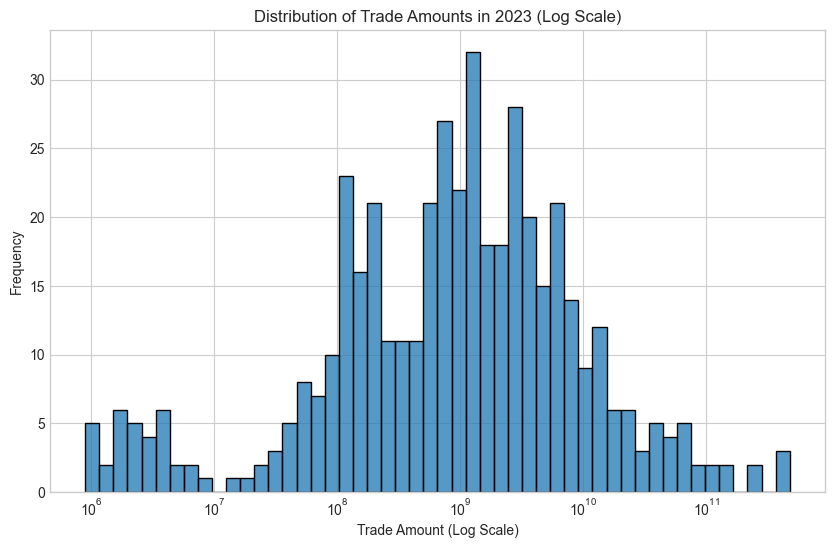

In [47]:
if not df_2023.empty:
    print(f"\n--- EDA for {STATIC_ANALYSIS_YEAR} ---")
    top_importers_2023 = df_2023.groupby('importer')['amount'].sum().nlargest(TOP_N_CENTRALITY)
    print("\nTop Importers (by total import amount):")
    print(top_importers_2023)

    top_exporters_2023 = df_2023.groupby('exporter')['amount'].sum().nlargest(TOP_N_CENTRALITY)
    print("\nTop Exporters (by total export amount):")
    print(top_exporters_2023)

    plt.figure(figsize=(10, 6))
    sns.histplot(df_2023['amount'], bins=50, kde=False, log_scale=True)
    plt.title(f'Distribution of Trade Amounts in {STATIC_ANALYSIS_YEAR} (Log Scale)')
    plt.xlabel('Trade Amount (Log Scale)')
    plt.ylabel('Frequency')
    plt.savefig('trade_distribution_2023.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping EDA as no data is available for the selected year after cleaning.")

## 4. Graph Construction for 2023
Using the cleaned 2023 snapshot, a directed graph (`DiGraph`) is constructed with `networkx`. Countries are represented as nodes, and trade flows are represented as weighted, directed edges from the exporter to the importer. Each node is enriched with attributes for geographic coordinates, total exports, total imports, total trade, and trade balance. The resulting graph for 2023 consists of **79 nodes** and **460 edges**, forming the basis for all subsequent network analysis.

In [48]:
G_2023 = nx.DiGraph()
trade_aggregated_2023 = pd.DataFrame() # Initialize

if not df_2023.empty:
    trade_aggregated_2023 = df_2023.groupby([
        'exporter', 'importer', 
        'exporter_longitude', 'exporter_latitude', 
        'importer_longitude', 'importer_latitude'
    ])['amount'].sum().reset_index()

    for _, row in trade_aggregated_2023.iterrows():
        exporter, importer, amount = row["exporter"], row["importer"], row["amount"]
        if exporter not in G_2023: G_2023.add_node(exporter, lon=row["exporter_longitude"], lat=row["exporter_latitude"])
        if importer not in G_2023: G_2023.add_node(importer, lon=row["importer_longitude"], lat=row["importer_latitude"])
        G_2023.add_edge(exporter, importer, weight=amount)

    exports_2023 = trade_aggregated_2023.groupby('exporter')['amount'].sum()
    imports_2023 = trade_aggregated_2023.groupby('importer')['amount'].sum()

    for node in G_2023.nodes():
        G_2023.nodes[node]['total_exports'] = exports_2023.get(node, 0)
        G_2023.nodes[node]['total_imports'] = imports_2023.get(node, 0)
        G_2023.nodes[node]['total_trade'] = G_2023.nodes[node]['total_exports'] + G_2023.nodes[node]['total_imports']
        G_2023.nodes[node]['trade_balance'] = G_2023.nodes[node]['total_exports'] - G_2023.nodes[node]['total_imports']
        # Ensure lon/lat are present from initial node addition
        if 'lon' not in G_2023.nodes[node] or 'lat' not in G_2023.nodes[node]:
             print(f"Warning: Node {node} missing coordinates after initial graph build.")

    print(f"Graph for {STATIC_ANALYSIS_YEAR} constructed: {G_2023.number_of_nodes()} nodes, {G_2023.number_of_edges()} edges.")

    # Prepare for visualization
    nodes_2023 = list(G_2023.nodes())
    total_trades_list = [G_2023.nodes[n]['total_trade'] for n in nodes_2023]
    node_sizes_2023 = []
    if total_trades_list:
        min_tt, max_tt = (min(total_trades_list), max(total_trades_list)) if total_trades_list else (0,0)
        node_sizes_2023 = [((t - min_tt) / (max_tt - min_tt) * 950 + 50) if max_tt > min_tt else 100 for t in total_trades_list]
    
    edge_amounts_list = [d['weight'] for u,v,d in G_2023.edges(data=True)]
    edge_weights_2023_norm = []
    if edge_amounts_list:
        min_ea, max_ea = (min(edge_amounts_list), max(edge_amounts_list)) if edge_amounts_list else (0,0)
        edge_weights_2023_norm = [((w - min_ea) / (max_ea - min_ea) * 4.9 + 0.1) if max_ea > min_ea else 1 for w in edge_amounts_list]

    nodes_to_label_2023 = set()
    if len(nodes_2023) > 0 :
        node_info_list = [{'name': n, 'lon': G_2023.nodes[n].get('lon'), 'lat': G_2023.nodes[n].get('lat'), 'total_trade': G_2023.nodes[n]['total_trade']} for n in nodes_2023 if G_2023.nodes[n].get('lon') is not None]
        node_info_sorted = sorted(node_info_list, key=lambda x: x['total_trade'], reverse=True)
        nodes_to_label_2023 = set(ni['name'] for ni in node_info_sorted[:20]) # Label top 20 by trade initially
        # Decluttering (simplified)
        # For more sophisticated decluttering, consider libraries or more complex logic.
        # This basic version just takes the top N by trade volume.
    print(f"Selected {len(nodes_to_label_2023)} nodes for potential labeling on maps.")
else:
    print(f"Graph for {STATIC_ANALYSIS_YEAR} could not be constructed as no data is available.")

Graph for 2023 constructed: 79 nodes, 460 edges.
Selected 20 nodes for potential labeling on maps.


## 5. Basic Network Properties (2023)
The fundamental properties of the 2023 trade network are calculated. The network has a density of **0.0747**, indicating that about 7.5% of all possible directed connections between countries exist. The average clustering coefficient of the corresponding undirected network is **0.2934**, suggesting a moderate level of local cohesiveness. The average shortest path length is **2.4330**, meaning that, on average, any two countries in the network are separated by less than 3 trade intermediaries.

In [49]:
if G_2023.number_of_nodes() > 0:
    print(f"--- Network Properties for {STATIC_ANALYSIS_YEAR} ---")
    density = nx.density(G_2023)
    print(f"Density: {density:.4f}")

    G_2023_undirected = G_2023.to_undirected()
    avg_clustering = nx.average_clustering(G_2023_undirected) # Unweighted clustering
    print(f"Average Clustering Coefficient (undirected, unweighted): {avg_clustering:.4f}")

    if nx.is_connected(G_2023_undirected):
        avg_shortest_path = nx.average_shortest_path_length(G_2023_undirected)
        print(f"Avg Shortest Path Length (undirected, unweighted, connected graph): {avg_shortest_path:.4f}")
    else:
        if G_2023_undirected.number_of_nodes() > 1:
            largest_cc = max(nx.connected_components(G_2023_undirected), key=len)
            G_lcc_undir = G_2023_undirected.subgraph(largest_cc)
            if G_lcc_undir.number_of_nodes() > 1:
                avg_shortest_path_lcc = nx.average_shortest_path_length(G_lcc_undir)
                print(f"Avg Shortest Path Length (LCC of undirected, unweighted graph): {avg_shortest_path_lcc:.4f}")
            else: print("LCC of undirected graph has <=1 node.")
        else: print("Undirected graph has <=1 node.")
else:
    print("Graph is empty, skipping basic property calculations.")

--- Network Properties for 2023 ---
Density: 0.0747
Average Clustering Coefficient (undirected, unweighted): 0.2934
Avg Shortest Path Length (undirected, unweighted, connected graph): 2.4330


## 6. Node Importance: Centrality Measures (2023)
To identify the most influential countries in the 2023 trade network, a comprehensive set of centrality measures is calculated. This includes weighted degrees, Betweenness, Eigenvector, **PageRank**, **HITS** (Hubs & Authorities), and Harmonic Centrality, addressing the instructor's recommendations. The results are normalized and presented in bar charts, showing the top 10 countries for each metric. A composite score is also calculated to provide a single, aggregated measure of influence. These analyses reveal which countries act as major importers, exporters, intermediaries, and overall influential players.

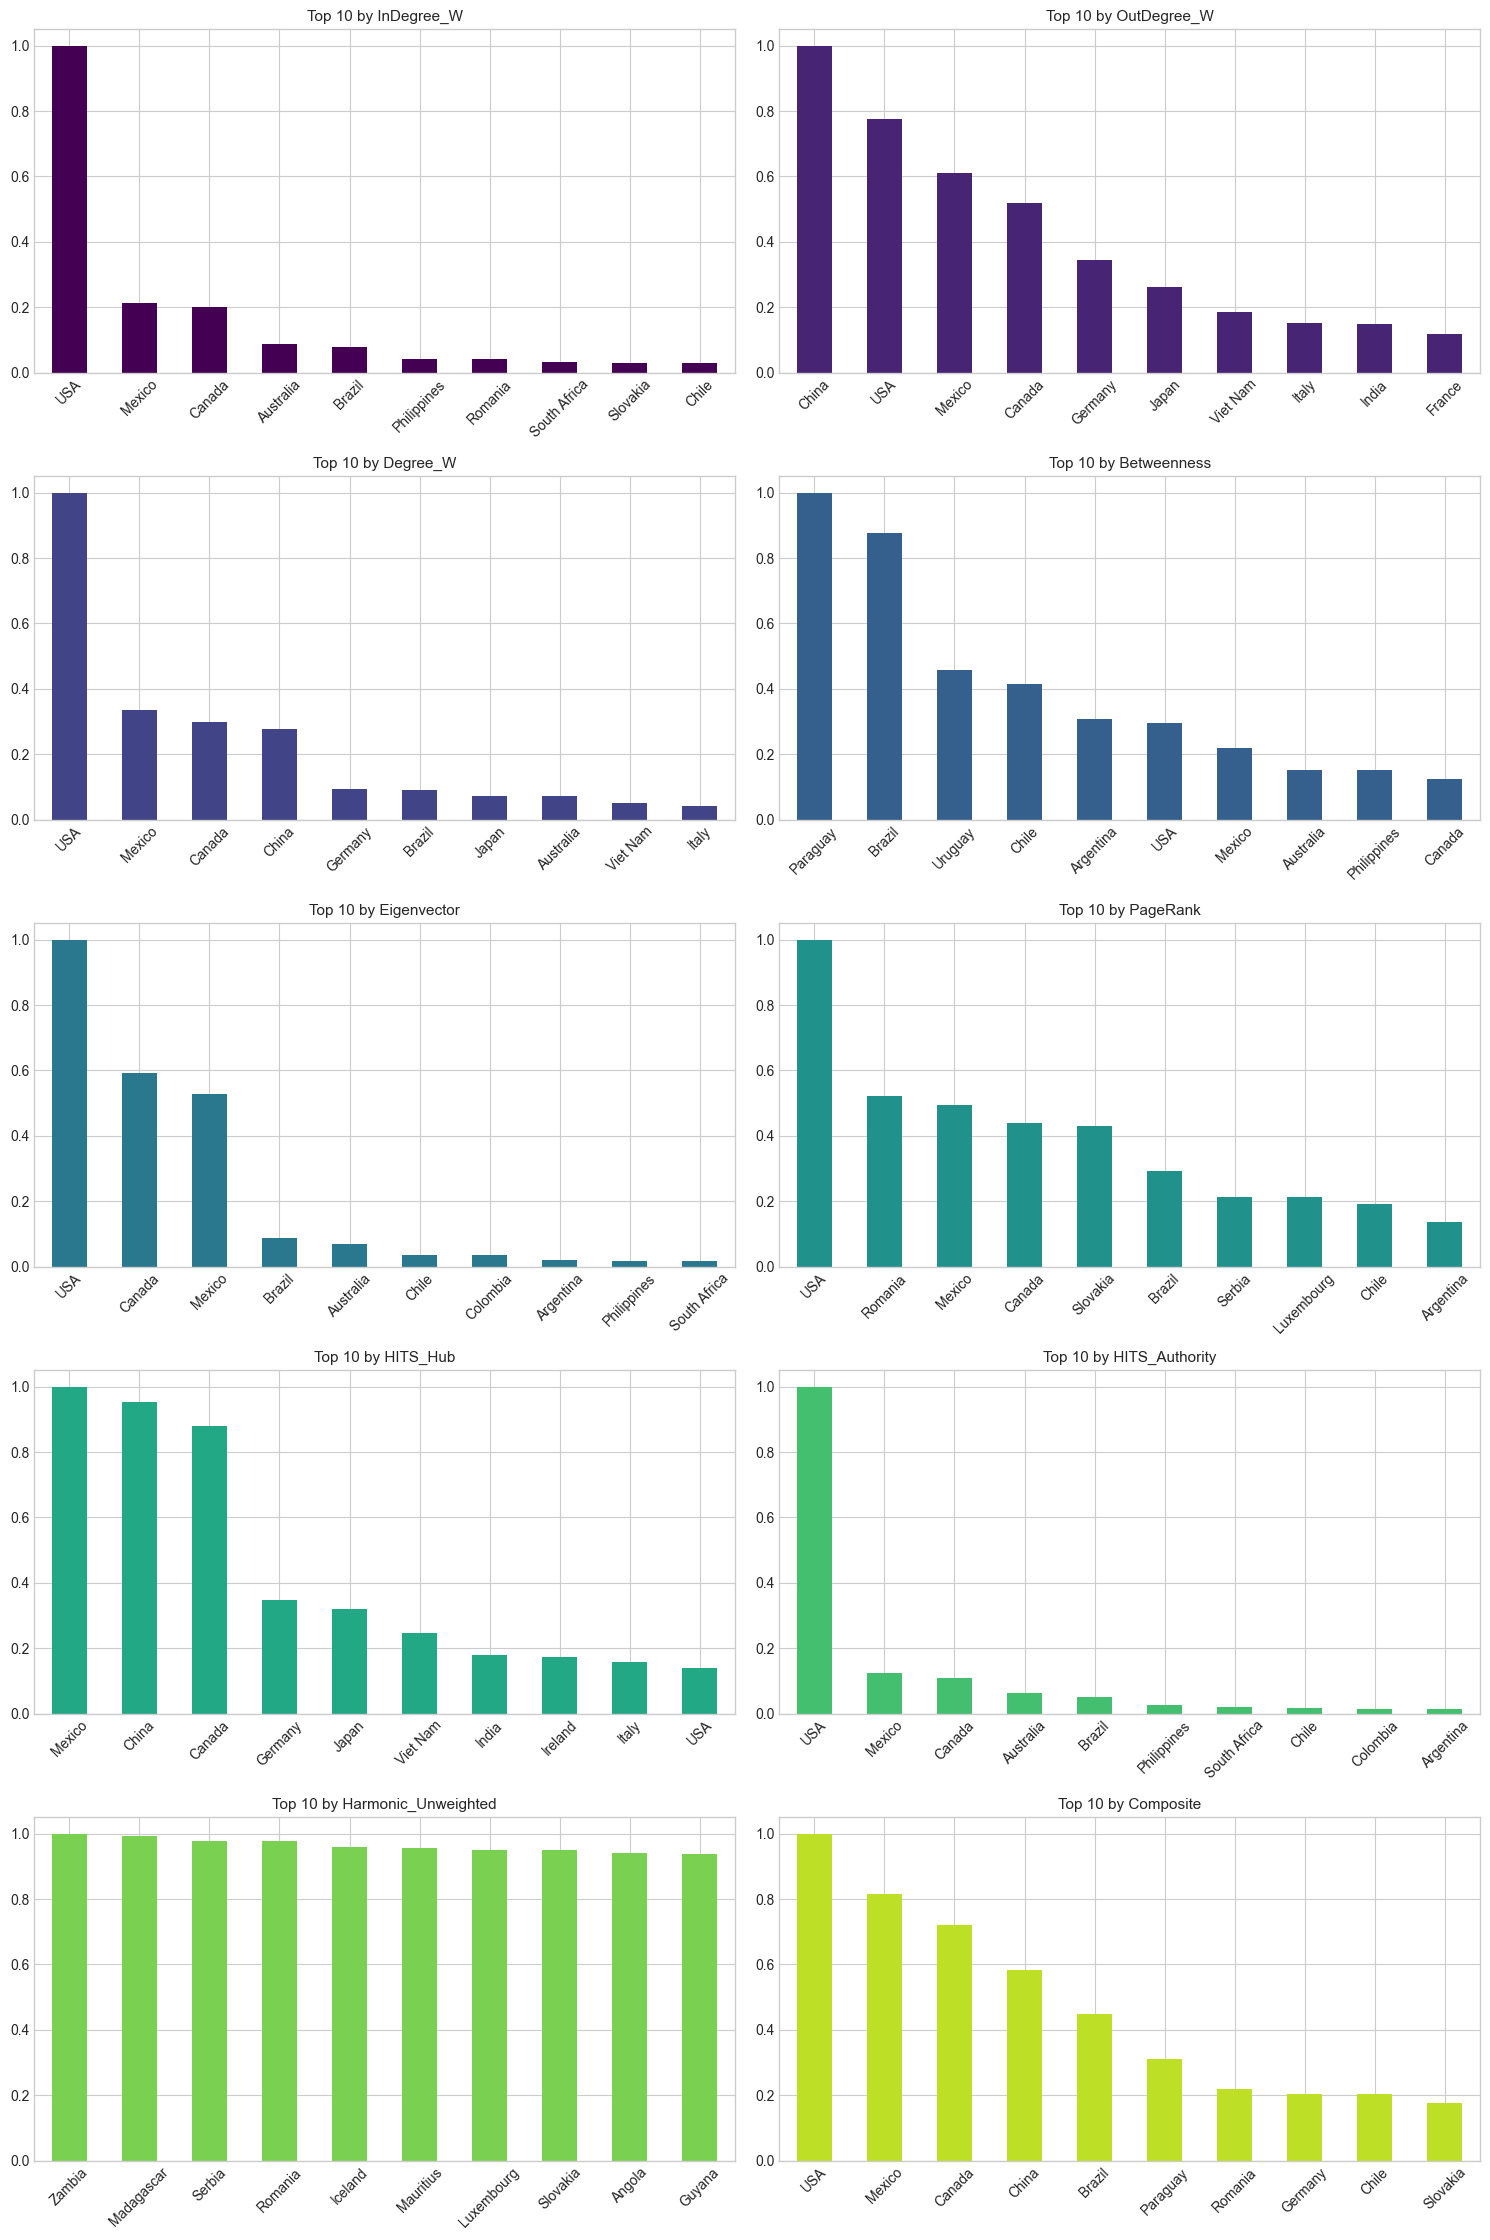

In [50]:
centrality_df_2023 = pd.DataFrame(index=list(G_2023.nodes()))
if G_2023.number_of_nodes() > 0:
    centrality_df_2023['InDegree_W'] = pd.Series(dict(G_2023.in_degree(weight='weight')))
    centrality_df_2023['OutDegree_W'] = pd.Series(dict(G_2023.out_degree(weight='weight')))
    centrality_df_2023['Degree_W'] = pd.Series(dict(G_2023.degree(weight='weight')))
    
    try: 
        centrality_df_2023['Betweenness'] = pd.Series(nx.betweenness_centrality(G_2023, weight='weight', normalized=True))
    except: 
        centrality_df_2023['Betweenness'] = pd.Series(nx.betweenness_centrality(G_2023, normalized=True))
    
    try: 
        centrality_df_2023['Eigenvector'] = pd.Series(nx.eigenvector_centrality_numpy(G_2023, weight='weight', max_iter=1000, tol=1e-03))
    except:
        try: 
            centrality_df_2023['Eigenvector'] = pd.Series(nx.eigenvector_centrality_numpy(G_2023.to_undirected(), weight='weight', max_iter=1000, tol=1e-03))
        except: 
            centrality_df_2023['Eigenvector'] = 0
    
    try: 
        centrality_df_2023['PageRank'] = pd.Series(nx.pagerank(G_2023, weight='weight'))
    except: 
        centrality_df_2023['PageRank'] = pd.Series(nx.pagerank(G_2023))
    
    try:
        h, a = nx.hits(G_2023, max_iter=1000, tol=1e-03)
        centrality_df_2023['HITS_Hub'] = pd.Series(h)
        centrality_df_2023['HITS_Authority'] = pd.Series(a)
    except:
        G_temp_unweighted_hits = nx.DiGraph(G_2023)
        h, a = nx.hits(G_temp_unweighted_hits, max_iter=5000, tol=1e-04)
        centrality_df_2023['HITS_Hub'] = pd.Series(h)
        centrality_df_2023['HITS_Authority'] = pd.Series(a)
    
    centrality_df_2023['Harmonic_Unweighted'] = pd.Series(nx.harmonic_centrality(G_2023))
    centrality_df_2023.fillna(0, inplace=True)

    scaler = MinMaxScaler()
    for col in centrality_df_2023.columns:
        if centrality_df_2023[col].nunique() > 1:
            centrality_df_2023[col] = scaler.fit_transform(centrality_df_2023[[col]])
        elif centrality_df_2023[col].nunique() == 1 and centrality_df_2023[col].iloc[0] != 0:
            centrality_df_2023[col] = 1.0
    
    weights_comp = {'OutDegree_W': 0.25, 'PageRank': 0.25, 'Betweenness': 0.20, 'HITS_Hub': 0.15, 'Eigenvector': 0.15}
    valid_weights_comp = {k: v for k,v in weights_comp.items() if k in centrality_df_2023.columns}
    if valid_weights_comp:
        centrality_df_2023['Composite'] = sum(centrality_df_2023[m] * w for m,w in valid_weights_comp.items())
        if centrality_df_2023['Composite'].nunique() > 1:
            centrality_df_2023['Composite'] = scaler.fit_transform(centrality_df_2023[['Composite']])
        elif centrality_df_2023['Composite'].nunique() == 1 and centrality_df_2023['Composite'].iloc[0] != 0:
            centrality_df_2023['Composite'] = 1.0
        for node in G_2023.nodes(): 
            G_2023.nodes[node]['composite_score'] = centrality_df_2023.loc[node, 'Composite'] if node in centrality_df_2023.index else 0

    plot_cols = [c for c in centrality_df_2023.columns if '_W' in c or c in ['Betweenness', 'Eigenvector', 'PageRank', 'HITS_Hub', 'HITS_Authority', 'Harmonic_Unweighted', 'Composite']]
    n_cols_plot = 2
    n_rows_plot = (len(plot_cols) + n_cols_plot - 1) // n_cols_plot
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, n_rows_plot * 4.5), squeeze=False)
    axes = axes.flatten()
    for i, measure in enumerate(plot_cols):
        if i < len(axes):
            top_n = centrality_df_2023[measure].sort_values(ascending=False).head(TOP_N_CENTRALITY)
            top_n.plot(kind='bar', ax=axes[i], color=plt.cm.viridis(i / len(plot_cols) if len(plot_cols)>0 else 0.5))
            axes[i].set_title(f'Top {TOP_N_CENTRALITY} by {measure}', fontsize=11)
            axes[i].tick_params(axis='x', rotation=45)
    for j in range(i + 1, len(axes)): 
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
else:
    print("Graph is empty, skipping centrality calculations.")

## 7. Community Detection (2023)
To identify clusters of tightly connected countries (trade blocs), several community detection algorithms are applied to the 2023 network. These include Louvain, **Spectral Clustering** (as recommended), Label Propagation, and others. The quality of the resulting partitions is evaluated using the modularity score. The results show that **Greedy Modularity** yields the highest modularity score of **0.1094**, identifying 4 distinct communities. This partition is selected as the best and used for subsequent visualization.

In [51]:
community_results_2023 = []
best_community_result = None # Initialize

if G_2023.number_of_nodes() > 0 and G_2023.number_of_edges() > 0:
    G_undirected_weighted_2023 = G_2023.to_undirected()
    for u, v, data in G_2023.edges(data=True):
        if G_undirected_weighted_2023.has_edge(u,v): G_undirected_weighted_2023[u][v]['weight'] = data.get('weight', 1)
    weight_key = 'weight'

    def partition_dict_to_list(p_dict): 
        cmap = {}
        for n, cid in p_dict.items(): cmap.setdefault(cid, set()).add(n)
        return list(cmap.values())
    def list_of_sets_to_partition_dict(l_sets):
        p_dict = {}
        for i, c_set in enumerate(l_sets): 
            for n in c_set: p_dict[n] = i
        return p_dict

    # 1. Louvain
    try:
        partition_louvain = community_louvain.best_partition(G_undirected_weighted_2023, weight=weight_key, random_state=42)
        mod_louvain = community_louvain.modularity(partition_louvain, G_undirected_weighted_2023, weight=weight_key)
        num_com_louvain = len(set(partition_louvain.values()))
        print(f"Louvain: {num_com_louvain} communities, Modularity: {mod_louvain:.4f}")
        community_results_2023.append({'Algorithm': 'Louvain', 'Num Communities': num_com_louvain, 'Modularity': mod_louvain, 'Partition': partition_louvain})
    except Exception as e: print(f"Louvain failed: {e}"); num_com_louvain = 5 # Fallback for k

    # 2. Spectral Clustering
    try:
        n_nodes_spec = G_undirected_weighted_2023.number_of_nodes()
        k_spec = num_com_louvain if 'num_com_louvain' in locals() and num_com_louvain is not None and num_com_louvain > 1 else 5
        if n_nodes_spec <= 1 or k_spec <=1 or n_nodes_spec <= k_spec : k_spec = max(2, n_nodes_spec -1) if n_nodes_spec > 1 else 1
        if k_spec > 1:
            node_list_spec = list(G_undirected_weighted_2023.nodes())
            adj_matrix_spec = nx.to_scipy_sparse_array(G_undirected_weighted_2023, nodelist=node_list_spec, weight=weight_key, dtype=np.float32)
            adj_matrix_spec.indices = adj_matrix_spec.indices.astype(np.int32)
            adj_matrix_spec.indptr = adj_matrix_spec.indptr.astype(np.int32)
            sc = SpectralClustering(n_clusters=k_spec, affinity='precomputed', assign_labels='kmeans', random_state=42)
            labels_spec = sc.fit_predict(adj_matrix_spec)
            partition_spec = {node: labels_spec[i] for i, node in enumerate(node_list_spec)}
            comms_spec_list = partition_dict_to_list(partition_spec)
            mod_spec = nx.community.modularity(G_undirected_weighted_2023, comms_spec_list, weight=weight_key) if comms_spec_list else 0
            print(f"Spectral Clustering (k={k_spec}): {len(comms_spec_list)} communities, Modularity: {mod_spec:.4f}")
            community_results_2023.append({'Algorithm': f'Spectral (k={k_spec})', 'Num Communities': len(comms_spec_list), 'Modularity': mod_spec, 'Partition': partition_spec})
        else: print("Skipping Spectral Clustering: k <= 1.")
    except Exception as e: print(f"Spectral Clustering failed: {e}")

    # Other algorithms (Label Prop, Async LPA, Greedy Mod, Girvan-Newman, FluidC)
    # Label Propagation
    try:
        comms_lpa = list(nx.community.label_propagation_communities(G_undirected_weighted_2023))
        mod_lpa = nx.community.modularity(G_undirected_weighted_2023, comms_lpa, weight=weight_key)
        print(f"Label Propagation: {len(comms_lpa)} communities, Modularity: {mod_lpa:.4f}")
        community_results_2023.append({'Algorithm': 'Label Propagation', 'Num Communities': len(comms_lpa), 'Modularity': mod_lpa, 'Partition': list_of_sets_to_partition_dict(comms_lpa)})
    except Exception as e: print(f"Label Propagation failed: {e}")

    # Async Label Propagation
    try:
        comms_asynclpa = list(nx.community.asyn_lpa_communities(G_undirected_weighted_2023, weight=weight_key, seed=42))
        mod_asynclpa = nx.community.modularity(G_undirected_weighted_2023, comms_asynclpa, weight=weight_key)
        print(f"Async LPA: {len(comms_asynclpa)} communities, Modularity: {mod_asynclpa:.4f}")
        community_results_2023.append({'Algorithm': 'Async LPA', 'Num Communities': len(comms_asynclpa), 'Modularity': mod_asynclpa, 'Partition': list_of_sets_to_partition_dict(comms_asynclpa)})
    except Exception as e: print(f"Async LPA failed: {e}")

    # Greedy Modularity
    try:
        comms_greedy_fs = nx.community.greedy_modularity_communities(G_undirected_weighted_2023, weight=weight_key)
        comms_greedy = [set(fs) for fs in comms_greedy_fs]
        mod_greedy = nx.community.modularity(G_undirected_weighted_2023, comms_greedy, weight=weight_key)
        print(f"Greedy Modularity: {len(comms_greedy)} communities, Modularity: {mod_greedy:.4f}")
        community_results_2023.append({'Algorithm': 'Greedy Modularity', 'Num Communities': len(comms_greedy), 'Modularity': mod_greedy, 'Partition': list_of_sets_to_partition_dict(comms_greedy)})
    except Exception as e: print(f"Greedy Modularity failed: {e}")

    # Girvan-Newman (limited levels)
    try:
        gn_gen = nx.community.girvan_newman(G_undirected_weighted_2023)
        max_gn_levels = 2 # Limited for performance
        best_mod_gn, best_comms_gn = -1.0, None
        for i, comms_level_fs in enumerate(gn_gen):
            if i >= max_gn_levels: break
            comms_level = [set(fs) for fs in comms_level_fs]
            if not comms_level or len(comms_level) <=1: continue
            mod_gn_level = nx.community.modularity(G_undirected_weighted_2023, comms_level, weight=weight_key)
            if mod_gn_level > best_mod_gn: best_mod_gn, best_comms_gn = mod_gn_level, comms_level
        if best_comms_gn:
            print(f"Girvan-Newman (Top {max_gn_levels}): {len(best_comms_gn)} communities, Modularity: {best_mod_gn:.4f}")
            community_results_2023.append({'Algorithm': f'Girvan-Newman (Top {max_gn_levels})', 'Num Communities': len(best_comms_gn), 'Modularity': best_mod_gn, 'Partition': list_of_sets_to_partition_dict(best_comms_gn)})
    except Exception as e: print(f"Girvan-Newman failed: {e}")

    # Fluid Communities
    try:
        k_fluid = num_com_louvain if 'num_com_louvain' in locals() and num_com_louvain is not None and num_com_louvain > 1 else 5
        if G_undirected_weighted_2023.number_of_nodes() <= k_fluid: k_fluid = max(2, G_undirected_weighted_2023.number_of_nodes() -1) if G_undirected_weighted_2023.number_of_nodes() > 1 else 1
        if k_fluid > 1:
            comms_fluid_raw = list(nx.community.asyn_fluidc(G_undirected_weighted_2023, k=k_fluid, seed=42))
            comms_fluid = [c for c in comms_fluid_raw if c]
            if not comms_fluid: comms_fluid = [set(G_undirected_weighted_2023.nodes())]
            mod_fluid = nx.community.modularity(G_undirected_weighted_2023, comms_fluid, weight=weight_key)
            print(f"Fluid Communities (k={k_fluid}): {len(comms_fluid)} communities, Modularity: {mod_fluid:.4f}")
            community_results_2023.append({'Algorithm': f'Fluid (k={k_fluid})', 'Num Communities': len(comms_fluid), 'Modularity': mod_fluid, 'Partition': list_of_sets_to_partition_dict(comms_fluid)})
        else: print("Skipping Fluid Communities: k <= 1.")
    except Exception as e: print(f"Fluid Communities failed: {e}")

    # Ground Truth Comparison (NMI)
    ground_truth_blocs = {
    'Albania': 'CEFTA',
    'Serbia': 'CEFTA',
    'Slovakia': 'EU',
    'USA': 'USMCA',
    'Algeria': 'AfCFTA',
    'Argentina': 'Mercosur',
    'Australia': 'CPTPP',
    'Brazil': 'BRICS',
    'Canada': 'USMCA',
    'Colombia': 'Pacific Alliance',
    'Philippines': 'ASEAN',
    'Romania': 'EU',
    'South Africa': 'BRICS',
    'Angola': 'AfCFTA',
    'Chile': 'Pacific Alliance',
    'Mauritius': 'AfCFTA',
    'Mexico': 'USMCA',
    'Paraguay': 'Mercosur',
    'Uruguay': 'Mercosur',
    'Armenia': 'EAEU',
    'Iceland': 'EFTA',
    'Austria': 'EU',
    'Luxembourg': 'EU',
    'Azerbaijan': 'EAEU',
    'Bahamas': 'CARICOM',
    'Bahrain': 'GCC',
    'Mozambique': 'AfCFTA',
    'Bangladesh': 'SAARC',
    'Belarus': 'EAEU',
    'Belgium': 'EU',
    'Madagascar': 'AfCFTA',
    'Bermuda': 'None',
    'Botswana': 'AfCFTA',
    'Brunei Darussalam': 'ASEAN',
    'Bulgaria': 'EU',
    'Cambodia': 'ASEAN',
    'Cameroon': 'AfCFTA',
    'Chad': 'AfCFTA',
    'China': 'BRICS',
    'Zambia': 'AfCFTA',
    'Congo': 'AfCFTA',
    'Costa Rica': 'CAFTA',
    'Croatia': 'EU',
    'Cuba': 'None',
    'Cyprus': 'EU',
    "Côte d'Ivoire": 'AfCFTA',
    'Denmark': 'EU',
    'Ecuador': 'Mercosur',
    'Egypt': 'AfCFTA',
    'El Salvador': 'CACM',
    'Equatorial Guinea': 'AfCFTA',
    'Estonia': 'EU',
    'Ethiopia': 'AfCFTA',
    'Fiji': 'PIF',
    'Finland': 'EU',
    'France': 'EU',
    'Gabon': 'AfCFTA',
    'Georgia': 'DCFTA',
    'Germany': 'EU',
    'Ghana': 'AfCFTA',
    'Greece': 'EU',
    'Guatemala': 'CACM',
    'Guyana': 'CARICOM',
    'Haiti': 'CARICOM',
    'Honduras': 'CACM',
    'Hungary': 'EU',
    'India': 'BRICS',
    'Indonesia': 'ASEAN',
    'Iraq': 'GAFTA',
    'Ireland': 'EU',
    'Israel': 'OECD',
    'Italy': 'EU',
    'Jamaica': 'CARICOM',
    'Japan': 'CPTPP',
    'Jordan': 'GAFTA',
    'Kazakhstan': 'EAEU',
    'Kenya': 'AfCFTA',
    'Kuwait': 'GCC',
    'Latvia': 'EU',
    'Lebanon': 'GAFTA',
    'Lesotho': 'AfCFTA',
    'Lithuania': 'EU',
    'Malaysia': 'ASEAN',
    'Mali': 'AfCFTA',
    'Malta': 'EU',
    'Mauritania': 'AfCFTA',
    'Montenegro': 'CEFTA',
    'Morocco': 'AfCFTA',
    'Myanmar': 'ASEAN',
    'Namibia': 'AfCFTA',
    'Nepal': 'SAARC',
    'Netherlands': 'EU',
    'New Zealand': 'CPTPP',
    'Nicaragua': 'CACM',
    'Nigeria': 'AfCFTA',
    'Norway': 'EFTA',
    'Oman': 'GCC',
    'Pakistan': 'SAARC',
    'Panama': 'CAFTA',
    'Papua New Guinea': 'PIF',
    'Peru': 'Pacific Alliance',
    'Poland': 'EU',
    'Portugal': 'EU',
    'Qatar': 'GCC',
    'Russian Federation': 'BRICS',
    'Saudi Arabia': 'GCC',
    'Senegal': 'AfCFTA',
    'Seychelles': 'AfCFTA',
    'Singapore': 'ASEAN',
    'Slovenia': 'EU',
    'Spain': 'EU',
    'Sri Lanka': 'SAARC',
    'Suriname': 'CARICOM',
    'Sweden': 'EU',
    'Switzerland': 'EFTA',
    'Thailand': 'ASEAN',
    'Togo': 'AfCFTA',
    'Trinidad and Tobago': 'CARICOM',
    'Tunisia': 'AfCFTA',
    'Turkmenistan': 'None',
    'Uganda': 'AfCFTA',
    'Ukraine': 'DCFTA',
    'United Arab Emirates': 'GCC',
    'United Kingdom': 'None',
    'Uzbekistan': 'EAEU',
    'Viet Nam': 'ASEAN',
    'Zimbabwe': 'AfCFTA'
}
    nodes_in_graph_comm = list(G_undirected_weighted_2023.nodes())
    gt_labels_nmi = [ground_truth_blocs.get(node, 'Other') for node in nodes_in_graph_comm]
    for res in community_results_2023:
        if res.get('Partition') and isinstance(res['Partition'], dict):
            detected_labels_nmi = [res['Partition'].get(node) for node in nodes_in_graph_comm]
            valid_indices_nmi = [i for i, lbl in enumerate(detected_labels_nmi) if lbl is not None]
            if len(valid_indices_nmi) > 1 and len(set(gt_labels_nmi)) > 1 and len(set([detected_labels_nmi[i] for i in valid_indices_nmi])) > 1:
                aligned_gt = [gt_labels_nmi[i] for i in valid_indices_nmi]
                aligned_detected = [detected_labels_nmi[i] for i in valid_indices_nmi]
                try: res['NMI_vs_GT'] = normalized_mutual_info_score(aligned_gt, aligned_detected, average_method='arithmetic')
                except: res['NMI_vs_GT'] = np.nan
            else: res['NMI_vs_GT'] = np.nan
        else: res['NMI_vs_GT'] = np.nan

    df_comm_res = pd.DataFrame([r for r in community_results_2023 if r.get('Modularity') is not None or r.get('NMI_vs_GT') is not None])
    if not df_comm_res.empty:
        print("\n--- Community Detection Algorithm Comparison ---")
        display(HTML(df_comm_res.sort_values(by=['Modularity', 'NMI_vs_GT'], ascending=[False, False]).to_html(float_format="%.4f")))
        best_community_result = df_comm_res.sort_values(by='Modularity', ascending=False).iloc[0].to_dict() if not df_comm_res[df_comm_res['Modularity'].notna()].empty else None
    else: print("No valid community detection results.")
else:
    print("Graph is empty or has no edges, skipping community detection.")

Louvain: 3 communities, Modularity: 0.1028
Spectral Clustering (k=3): 3 communities, Modularity: 0.0346
Label Propagation: 1 communities, Modularity: 0.0000
Async LPA: 1 communities, Modularity: 0.0000
Greedy Modularity: 4 communities, Modularity: 0.1094
Girvan-Newman (Top 2): 2 communities, Modularity: -0.0000
Fluid Communities (k=3): 3 communities, Modularity: 0.0414

--- Community Detection Algorithm Comparison ---


,Algorithm,Num Communities,Modularity,Partition,NMI_vs_GT
4,Greedy Modularity,4,0.1094,"{'Iraq': 0, 'Zambia': 0, 'Slovakia': 0, 'Germany': 0, 'Ukraine': 0, 'Lithuania': 0, 'Oman': 0, 'Romania': 0, 'Austria': 0, 'Belgium': 0, 'Jamaica': 0, 'Poland': 0, 'Egypt': 0, 'Mauritius': 0, 'Qatar': 0, 'Iceland': 0, 'Netherlands': 0, 'Portugal': 0, 'Togo': 0, 'Seychelles': 0, 'United Arab Emirates': 0, 'Bahrain': 0, 'Israel': 0, 'Madagascar': 0, 'Slovenia': 0, 'Greece': 0, 'Kuwait': 0, 'Denmark': 0, 'South Africa': 0, 'Italy': 0, 'Mozambique': 0, 'Pakistan': 0, 'Nigeria': 0, 'Luxembourg': 0, 'Norway': 0, 'Hungary': 0, 'Serbia': 0, 'Croatia': 0, 'Angola': 0, 'Kazakhstan': 0, 'Finland': 0, 'Bulgaria': 0, 'Guyana': 1, 'Ireland': 1, 'Viet Nam': 1, 'USA': 1, 'Panama': 1, 'Sweden': 1, 'Canada': 1, 'India': 1, 'Japan': 1, 'Guatemala': 1, 'Suriname': 1, 'Switzerland': 1, 'United Kingdom': 1, 'China': 1, 'Mexico': 1, 'Morocco': 2, 'Uruguay': 2, 'Trinidad and Tobago': 2, 'France': 2, 'Ecuador': 2, 'Paraguay': 2, 'Brazil': 2, 'Argentina': 2, 'Peru': 2, 'Colombia': 2, 'Russian Federation': 2, 'Saudi Arabia': 2, 'Chile': 2, 'Spain': 2, 'Brunei Darussalam': 3, 'Australia': 3, 'Malaysia': 3, 'Philippines': 3, 'Singapore': 3, 'Indonesia': 3, 'Thailand': 3, 'New Zealand': 3}",0.4029
0,Louvain,3,0.1028,"{'Argentina': 1, 'Brazil': 1, 'Chile': 1, 'Colombia': 1, 'Madagascar': 1, 'Mauritius': 1, 'Paraguay': 1, 'Uruguay': 1, 'Australia': 2, 'Iceland': 0, 'Philippines': 2, 'Zambia': 1, 'Austria': 0, 'Luxembourg': 0, 'Mexico': 2, 'Romania': 0, 'Serbia': 0, 'Slovakia': 0, 'Bahrain': 1, 'Mozambique': 1, 'South Africa': 1, 'Belgium': 0, 'Angola': 1, 'Canada': 2, 'USA': 2, 'Guyana': 2, 'Brunei Darussalam': 2, 'Bulgaria': 0, 'China': 2, 'Croatia': 0, 'Denmark': 0, 'Ecuador': 1, 'Egypt': 1, 'Finland': 0, 'France': 1, 'Germany': 0, 'Greece': 0, 'Guatemala': 2, 'Hungary': 0, 'India': 2, 'Indonesia': 2, 'Iraq': 0, 'Ireland': 2, 'Israel': 1, 'Italy': 0, 'Jamaica': 0, 'Japan': 2, 'Kazakhstan': 0, 'Kuwait': 0, 'Lithuania': 0, 'Malaysia': 2, 'Morocco': 1, 'Netherlands': 0, 'New Zealand': 2, 'Nigeria': 1, 'Norway': 0, 'Oman': 1, 'Pakistan': 1, 'Panama': 2, 'Peru': 1, 'Poland': 0, 'Portugal': 1, 'Qatar': 1, 'Russian Federation': 1, 'Saudi Arabia': 1, 'Seychelles': 1, 'Singapore': 2, 'Slovenia': 0, 'Spain': 1, 'Suriname': 2, 'Sweden': 0, 'Switzerland': 2, 'Thailand': 2, 'Togo': 1, 'Trinidad and Tobago': 1, 'Ukraine': 0, 'United Arab Emirates': 1, 'United Kingdom': 2, 'Viet Nam': 2}",0.4318
6,Fluid (k=3),3,0.0414,"{'Jamaica': 0, 'Norway': 0, 'Kuwait': 0, 'Denmark': 0, 'Sweden': 0, 'Iceland': 0, 'Portugal': 0, 'Finland': 0, 'Lithuania': 0, 'United Kingdom': 0, 'Luxembourg': 0, 'Iraq': 1, 'Greece': 1, 'Poland': 1, 'Hungary': 1, 'Slovenia': 1, 'Serbia': 1, 'Slovakia': 1, 'Croatia': 1, 'Kazakhstan': 1, 'Ukraine': 1, 'Russian Federation': 1, 'Romania': 1, 'Bulgaria': 1, 'Austria': 1, 'Belgium': 1, 'Guyana': 2, 'Trinidad and Tobago': 2, 'Zambia': 2, 'Viet Nam': 2, 'Uruguay': 2, 'Paraguay': 2, 'Australia': 2, 'Canada': 2, 'Argentina': 2, 'Germany': 2, 'Oman': 2, 'Chile': 2, 'Thailand': 2, 'Mexico': 2, 'Indonesia': 2, 'Morocco': 2, 'Panama': 2, 'Egypt': 2, 'Brazil': 2, 'Malaysia': 2, 'Mauritius': 2, 'Netherlands': 2, 'Philippines': 2, 'Qatar': 2, 'Togo': 2, 'United Arab Emirates': 2, 'Seychelles': 2, 'Colombia': 2, 'Bahrain': 2, 'Saudi Arabia': 2, 'Israel': 2, 'Madagascar': 2, 'Peru': 2, 'Ireland': 2, 'USA': 2, 'South Africa': 2, 'Italy': 2, 'Brunei Darussalam': 2, 'Ecuador': 2, 'Japan': 2, 'Mozambique': 2, 'Pakistan': 2, 'Singapore': 2, 'Switzerland': 2, 'France': 2, 'Nigeria': 2, 'Spain': 2, 'Angola': 2, 'India': 2, 'Guatemala': 2, 'Suriname': 2, 'China': 2, 'New Zealand': 2}",0.2633
1,Spectral (k=3),3,0.0346,"{'Argentina': 0, 'Brazil': 0, 'Chile': 0, 'Colombia': 0, 'Madagascar': 0, 'Mauritius': 0, 'Paraguay': 0, 'Uruguay': 0, 'Australia': 0, 'Iceland': 1, 'Philippines': 0, 'Zambia': 0, 'Austria': 2, 'Luxembourg': 0, 'Mexico': 0, 'Romania': 2, 'Serbia': 2, 'Slovakia': 2, 'Bahrain': 0, 

## 8. Network Visualizations on World Map (2023)
The 2023 trade network is visualized on a world map using `cartopy`. Nodes (countries) are sized based on their total trade volume and colored by their composite centrality score, providing an intuitive view of the network's structure and the geographic distribution of influential trade hubs. A second map is generated to visualize the communities detected by the best-performing algorithm (Greedy Modularity), with each community assigned a distinct color. This helps in understanding the geographic clustering of trade blocs.

C:\Users\Askeladd\AppData\Local\Temp\ipykernel_34940\812741754.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm_cmap = cm.get_cmap('viridis')


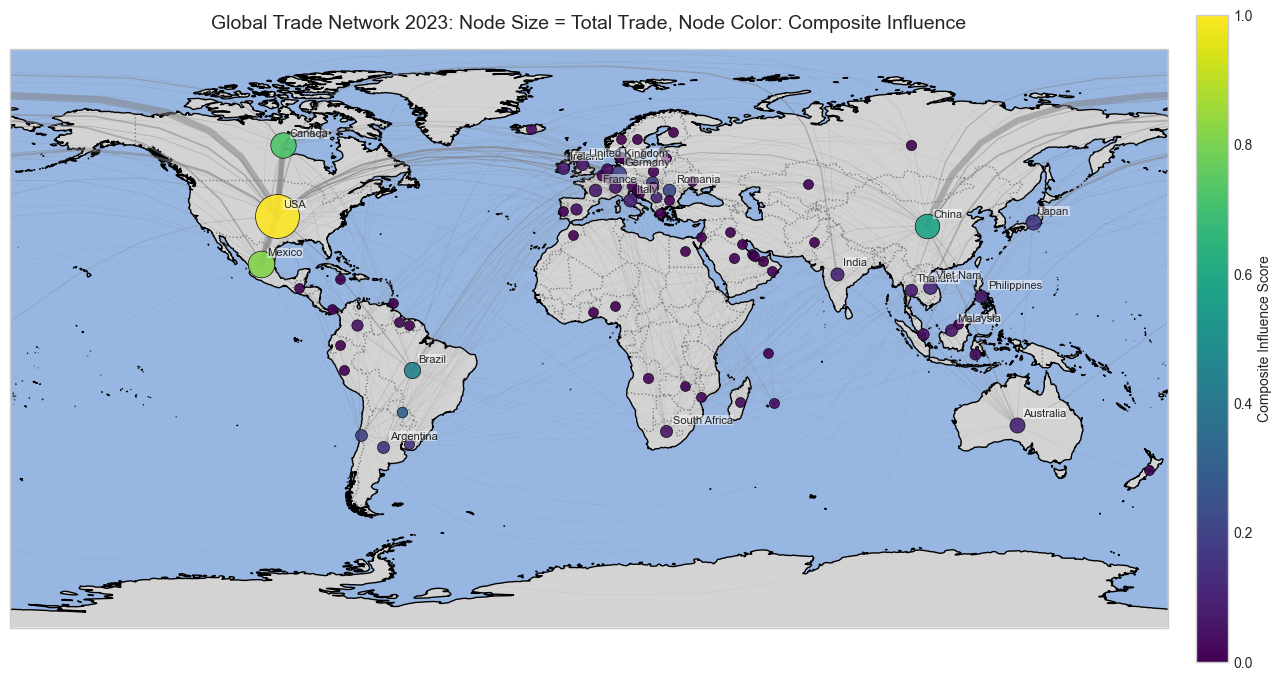

In [52]:
if G_2023.number_of_nodes() > 0 and all(isinstance(G_2023.nodes[n].get('lon'), (int, float)) for n in G_2023.nodes()):
    plt.figure(figsize=(18, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', edgecolor='gray', zorder=1)
    ax.coastlines(resolution='50m', zorder=1)
    ax.set_global()

    # Determine node color (Composite Score or Trade Balance)
    use_composite_color = 'composite_score' in G_2023.nodes[nodes_2023[0]] if nodes_2023 else False
    node_colors_viz_list = []
    cbar_label_viz, title_suffix_viz, sm_array, sm_cmap, sm_norm = "", "", [], None, None

    if use_composite_color:
        scores = [G_2023.nodes[n].get('composite_score', 0) for n in nodes_2023]
        sm_norm = plt.Normalize(min(scores) if scores else 0, max(scores) if scores else 1)
        sm_cmap = cm.get_cmap('viridis')
        node_colors_viz_list = [sm_cmap(sm_norm(s)) for s in scores]
        cbar_label_viz, title_suffix_viz, sm_array = 'Composite Influence Score', 'Node Color: Composite Influence', scores
    else:
        balances = [G_2023.nodes[n].get('trade_balance', 0) / G_2023.nodes[n].get('total_trade', 1) if G_2023.nodes[n].get('total_trade', 0) > 0 else 0 for n in nodes_2023]
        max_abs_bal = max(abs(min(balances)), abs(max(balances))) if balances else 1
        sm_norm = plt.Normalize(-max_abs_bal if max_abs_bal > 0 else -1, max_abs_bal if max_abs_bal > 0 else 1)
        sm_cmap = cm.get_cmap('RdYlBu')
        node_colors_viz_list = [sm_cmap(sm_norm(b)) for b in balances]
        cbar_label_viz, title_suffix_viz, sm_array = 'Normalized Trade Balance', 'Node Color: Norm. Trade Balance', balances

    # Plot Edges
    for i, (u,v,d) in enumerate(G_2023.edges(data=True)):
        ax.plot([G_2023.nodes[u]['lon'], G_2023.nodes[v]['lon']], [G_2023.nodes[u]['lat'], G_2023.nodes[v]['lat']],
                color='gray', linewidth=edge_weights_2023_norm[i] if edge_weights_2023_norm else 0.5, alpha=0.5, transform=ccrs.Geodetic(), zorder=2)
    # Plot Nodes
    for i, node in enumerate(nodes_2023):
        ax.scatter(G_2023.nodes[node]['lon'], G_2023.nodes[node]['lat'], s=node_sizes_2023[i] if node_sizes_2023 else 50,
                   color=node_colors_viz_list[i] if node_colors_viz_list else 'blue', edgecolor='black', linewidth=0.5, alpha=0.9, transform=ccrs.PlateCarree(), zorder=10)
        if node in nodes_to_label_2023:
            ax.text(G_2023.nodes[node]['lon'] + 2, G_2023.nodes[node]['lat'] + 2, node, fontsize=8, transform=ccrs.Geodetic(), ha='left', va='bottom', zorder=11, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.1))
    
    if sm_array and sm_cmap and sm_norm:
        sm = cm.ScalarMappable(cmap=sm_cmap, norm=sm_norm); sm.set_array(sm_array)
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, shrink=0.7); cbar.set_label(cbar_label_viz, fontsize=10)
    
    plt.title(f"Global Trade Network {STATIC_ANALYSIS_YEAR}: Node Size = Total Trade, {title_suffix_viz}", fontsize=14, pad=15)
    plt.savefig(f'trade_network_map_{STATIC_ANALYSIS_YEAR}.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping overall network map: Graph empty or coordinate data missing.")


Visualizing communities from: Greedy Modularity (Modularity: 0.1094)


C:\Users\Askeladd\AppData\Local\Temp\ipykernel_34940\423382639.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_c = cm.get_cmap('tab20' if len(comm_ids) <= 20 else 'viridis', len(comm_ids))


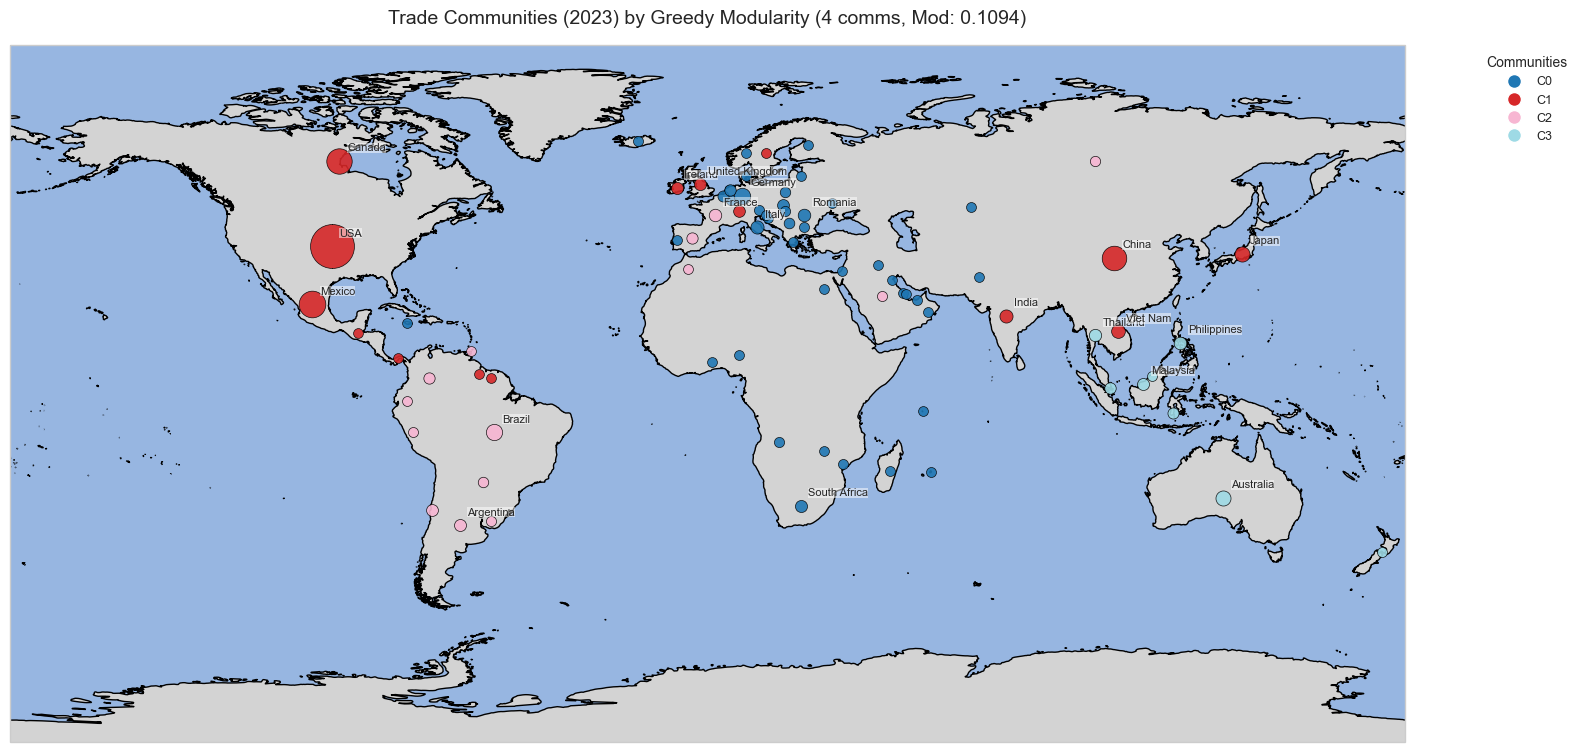

In [53]:
if 'best_community_result' in locals() and best_community_result and G_2023.number_of_nodes() > 0 and all(isinstance(G_2023.nodes[n].get('lon'), (int, float)) for n in G_2023.nodes()):
    algo_name, part_dict = best_community_result['Algorithm'], best_community_result['Partition']
    num_comms, mod_score = best_community_result['Num Communities'], best_community_result['Modularity']
    print(f"\nVisualizing communities from: {algo_name} (Modularity: {mod_score:.4f})")
    nx.set_node_attributes(G_2023, part_dict, "community_id")

    plt.figure(figsize=(18, 12))
    ax_c = plt.axes(projection=ccrs.PlateCarree()); ax_c.add_feature(cfeature.LAND.with_scale('50m'), fc='lightgray', zorder=0); ax_c.add_feature(cfeature.OCEAN.with_scale('50m'), zorder=0); ax_c.coastlines(resolution='50m', zorder=1); ax_c.set_global()
    comm_ids = sorted(list(set(val for val in part_dict.values() if val is not None)))
    if comm_ids:
        cmap_c = cm.get_cmap('tab20' if len(comm_ids) <= 20 else 'viridis', len(comm_ids))
        comm_color_map = {cid: cmap_c(i) for i, cid in enumerate(comm_ids)}
        for i, node in enumerate(nodes_2023):
            cid = G_2023.nodes[node].get('community_id', -1)
            ax_c.scatter(G_2023.nodes[node]['lon'], G_2023.nodes[node]['lat'], s=node_sizes_2023[i] if node_sizes_2023 else 50, color=comm_color_map.get(cid, 'grey'), ec='k', lw=0.5, alpha=0.9, transform=ccrs.PlateCarree(), zorder=10)
            if node in nodes_to_label_2023: ax_c.text(G_2023.nodes[node]['lon'] + 2, G_2023.nodes[node]['lat'] + 2, node, fontsize=8, transform=ccrs.Geodetic(), ha='left', va='bottom', zorder=11, bbox=dict(fc='w', alpha=0.5, ec='none', pad=0.1))
        if len(comm_ids) <= 20: handles = [plt.Line2D([0], [0], marker='o',c='w', label=f'C{cid}', ms=10, mfc=comm_color_map.get(cid)) for cid in comm_ids]; ax_c.legend(handles=handles, title="Communities", bbox_to_anchor=(1.05,1), loc='upper left', fontsize=9)
        plt.title(f"Trade Communities ({STATIC_ANALYSIS_YEAR}) by {algo_name} ({num_comms} comms, Mod: {mod_score:.4f})", fontsize=14, pad=15)
        plt.savefig(f'community_map_{STATIC_ANALYSIS_YEAR}_{algo_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("Skipping best community map: No result, empty graph, or missing coordinates.")

C:\Users\Askeladd\AppData\Local\Temp\ipykernel_34940\3602460922.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_gt_viz = cm.get_cmap('tab20b' if len(unique_blocs_gt) <= 20 else 'viridis', len(unique_blocs_gt) if unique_blocs_gt else 1)


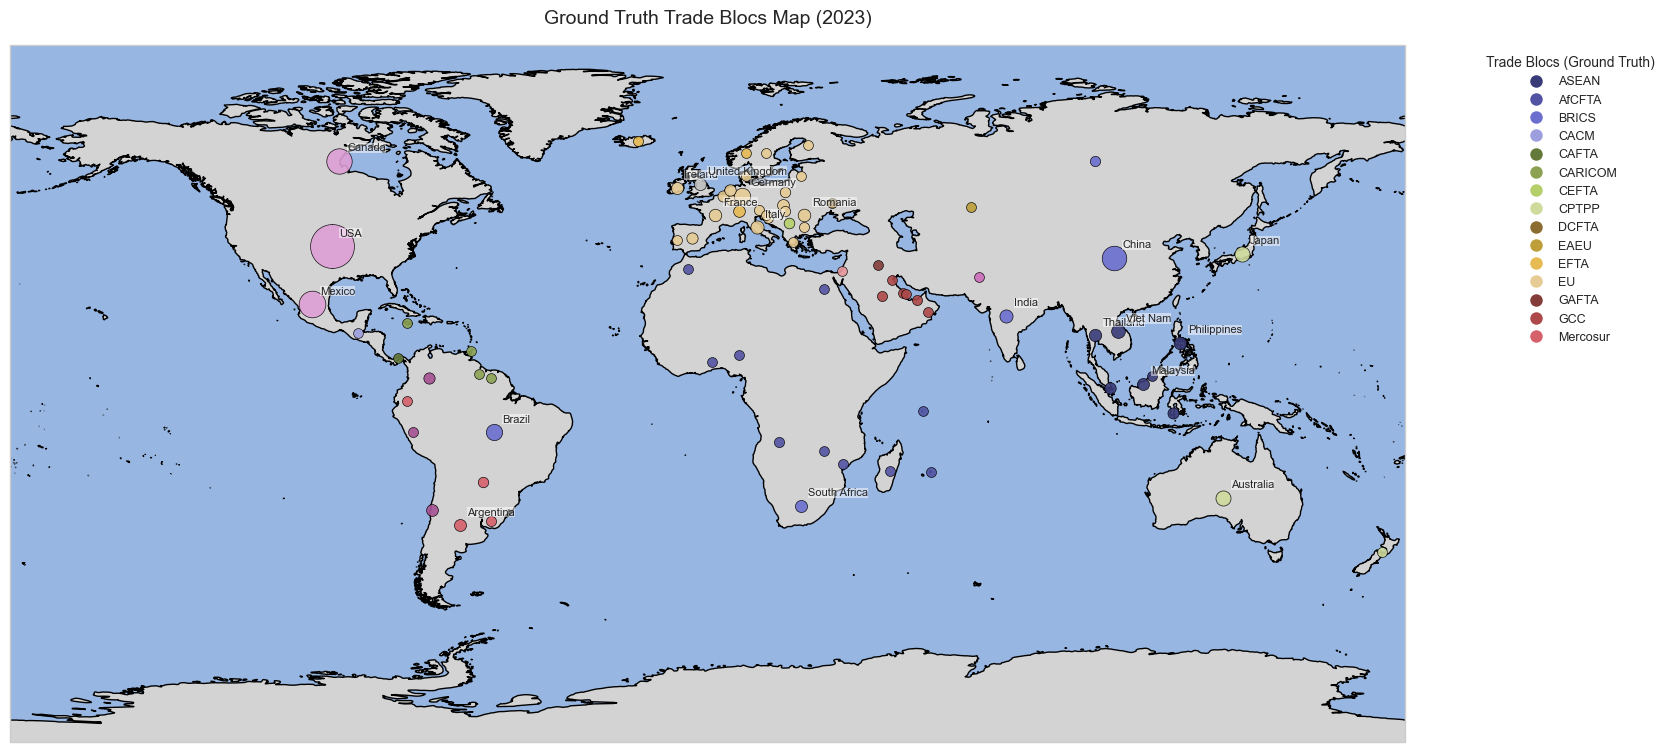

In [54]:
if G_2023.number_of_nodes() > 0 and all(isinstance(G_2023.nodes[n].get('lon'), (int, float)) for n in G_2023.nodes()):
    plt.figure(figsize=(18, 12))
    ax_gt = plt.axes(projection=ccrs.PlateCarree()); ax_gt.add_feature(cfeature.LAND.with_scale('50m'), fc='lightgray', zorder=0); ax_gt.add_feature(cfeature.OCEAN.with_scale('50m'), zorder=0); ax_gt.coastlines(resolution='50m', zorder=1); ax_gt.set_global()
    unique_blocs_gt = sorted(list(set(b for b in ground_truth_blocs.values() if b != 'Other' and b != 'None')))
    cmap_gt_viz = cm.get_cmap('tab20b' if len(unique_blocs_gt) <= 20 else 'viridis', len(unique_blocs_gt) if unique_blocs_gt else 1)
    bloc_color_map_viz = {bloc: cmap_gt_viz(i) for i, bloc in enumerate(unique_blocs_gt)}
    bloc_color_map_viz['Other'] = 'grey'
    bloc_color_map_viz['None'] = 'silver'

    for i, node in enumerate(nodes_2023):
        bloc = ground_truth_blocs.get(node, 'Other')
        ax_gt.scatter(G_2023.nodes[node]['lon'], G_2023.nodes[node]['lat'], s=node_sizes_2023[i] if node_sizes_2023 else 50, color=bloc_color_map_viz.get(bloc, 'lightgrey'), ec='k', lw=0.5, alpha=0.9, transform=ccrs.PlateCarree(), zorder=10)
        if node in nodes_to_label_2023: ax_gt.text(G_2023.nodes[node]['lon'] + 2, G_2023.nodes[node]['lat'] + 2, node, fontsize=8, transform=ccrs.Geodetic(), ha='left', va='bottom', zorder=11, bbox=dict(fc='w', alpha=0.5, ec='none', pad=0.1))
    
    handles_gt_viz = [plt.Line2D([0],[0], marker='o',c='w',label=b,ms=10,mfc=bloc_color_map_viz.get(b)) for b in unique_blocs_gt[:15]]
    if handles_gt_viz: ax_gt.legend(handles=handles_gt_viz, title="Trade Blocs (Ground Truth)", bbox_to_anchor=(1.05,1), loc='upper left', fontsize=9)
    plt.title(f"Ground Truth Trade Blocs Map ({STATIC_ANALYSIS_YEAR})", fontsize=14, pad=15)
    plt.savefig(f'ground_truth_map_{STATIC_ANALYSIS_YEAR}.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping ground truth map: Graph empty or missing coordinates.")

## 9. Advanced Structural Analysis (K-Cores, Cliques) for 2023
To delve deeper into the network's structure, k-core decomposition and maximal clique analysis are performed. The k-core analysis reveals a densely connected inner core of countries with a maximum core number of **12**. The maximal clique analysis identifies **227** fully-connected subgraphs (cliques) of 4 or more members, with the largest cliques consisting of 8 countries. These results highlight the existence of highly interconnected groups of nations that trade extensively with every other member of their group.


Highest k-core value: 12


C:\Users\Askeladd\AppData\Local\Temp\ipykernel_34940\3573767528.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_k = cm.get_cmap('viridis', max_k_core + 1); norm_k = plt.Normalize(vmin=0, vmax=max_k_core)


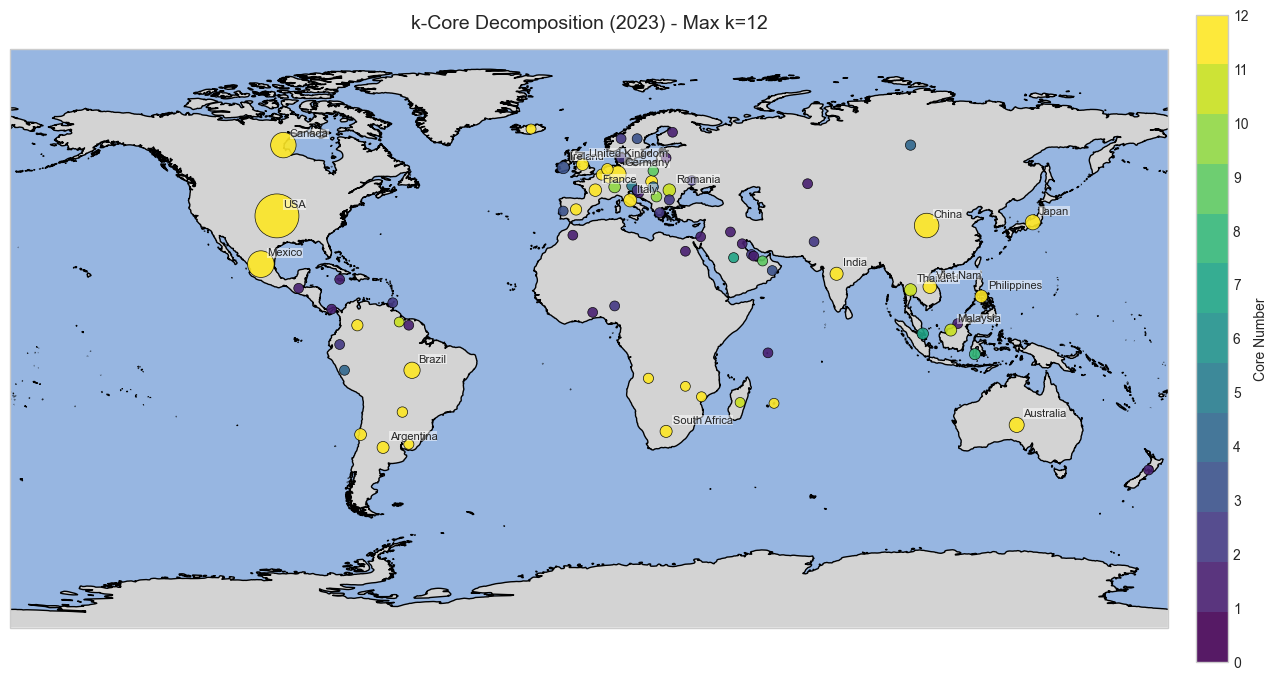


Finding maximal cliques...
Found 227 cliques with at least 4 members.
Top 5 largest cliques:
 Size 8: ['Argentina', 'Brazil', 'Chile', 'France', 'Mexico', 'Paraguay', 'USA', 'Uruguay']
 Size 8: ['Argentina', 'Brazil', 'Chile', 'Mexico', 'Paraguay', 'USA', 'Uruguay', 'Viet Nam']
 Size 8: ['Argentina', 'Brazil', 'Chile', 'Italy', 'Mexico', 'Paraguay', 'USA', 'Uruguay']
 Size 8: ['Argentina', 'Brazil', 'Chile', 'Japan', 'Mexico', 'Paraguay', 'USA', 'Uruguay']
 Size 8: ['Argentina', 'Brazil', 'Chile', 'Germany', 'Mexico', 'Paraguay', 'USA', 'Uruguay']


In [55]:
if G_2023.number_of_nodes() > 0:
    G_undir_adv = G_2023.to_undirected()
    G_undir_adv.remove_edges_from(nx.selfloop_edges(G_undir_adv))

    # K-Core Decomposition
    if G_undir_adv.number_of_nodes() > 0:
        core_numbers = nx.core_number(G_undir_adv)
        nx.set_node_attributes(G_2023, core_numbers, "core_number") # Add to original graph too
        max_k_core = max(core_numbers.values()) if core_numbers else 0
        print(f"\nHighest k-core value: {max_k_core}")
        if all(isinstance(G_2023.nodes[n].get('lon'), (int, float)) for n in G_2023.nodes()) and max_k_core > 0:
            plt.figure(figsize=(18,12)); ax_k = plt.axes(projection=ccrs.PlateCarree()); ax_k.add_feature(cfeature.LAND.with_scale('50m'), fc='lightgray', zorder=0); ax_k.add_feature(cfeature.OCEAN.with_scale('50m'), zorder=0); ax_k.coastlines(resolution='50m', zorder=1); ax_k.set_global()
            node_core_colors = [core_numbers.get(node,0) for node in nodes_2023]
            cmap_k = cm.get_cmap('viridis', max_k_core + 1); norm_k = plt.Normalize(vmin=0, vmax=max_k_core)
            sc_k = ax_k.scatter([G_2023.nodes[n]['lon'] for n in nodes_2023], [G_2023.nodes[n]['lat'] for n in nodes_2023], s=[node_sizes_2023[i] if node_sizes_2023 else 50 for i in range(len(nodes_2023))], c=node_core_colors, cmap=cmap_k, norm=norm_k, ec='k', lw=0.5, alpha=0.9, transform=ccrs.PlateCarree(), zorder=10)
            for i,node in enumerate(nodes_2023): 
                if node in nodes_to_label_2023: ax_k.text(G_2023.nodes[node]['lon']+2, G_2023.nodes[node]['lat']+2, node, fontsize=8, transform=ccrs.Geodetic(), ha='left', va='bottom', zorder=11, bbox=dict(fc='w',alpha=0.5,ec='none',pad=0.1))
            cbar_k = plt.colorbar(sc_k, ax=ax_k, ticks=range(max_k_core+1), pad=0.02, shrink=0.7); cbar_k.set_label('Core Number')
            plt.title(f'k-Core Decomposition ({STATIC_ANALYSIS_YEAR}) - Max k={max_k_core}', fontsize=14, pad=15); plt.savefig(f'kcore_map_{STATIC_ANALYSIS_YEAR}.png', dpi=300, bbox_inches='tight'); plt.show()

    # Maximal Cliques
    if G_undir_adv.number_of_edges() > 0: # Cliques require edges
        print("\nFinding maximal cliques...")
        maximal_cliques = list(nx.find_cliques(G_undir_adv))
        large_cliques = [c for c in maximal_cliques if len(c) >= MIN_CLIQUE_SIZE_FILTER]
        print(f"Found {len(large_cliques)} cliques with at least {MIN_CLIQUE_SIZE_FILTER} members.")
        if large_cliques: large_cliques.sort(key=len, reverse=True); print("Top 5 largest cliques:"); [print(f" Size {len(c)}: {sorted(c)}") for c in large_cliques[:5]]
else:
    print("Graph empty, skipping advanced structural analysis.")

## 10. Degree Distribution & Power Law Fit Analysis (2023)
The degree distributions (total, in, and out) of the weighted network are analyzed. The distributions are plotted and tested for power-law characteristics using the `powerlaw` library. The analysis indicates the presence of hubs, which is characteristic of scale-free networks, although formal fitting against power-law and log-normal distributions is complex. Additionally, the network's degree assortativity is calculated as **-0.1129**, indicating a slight tendency for high-degree nodes to connect with low-degree nodes (disassortativity).

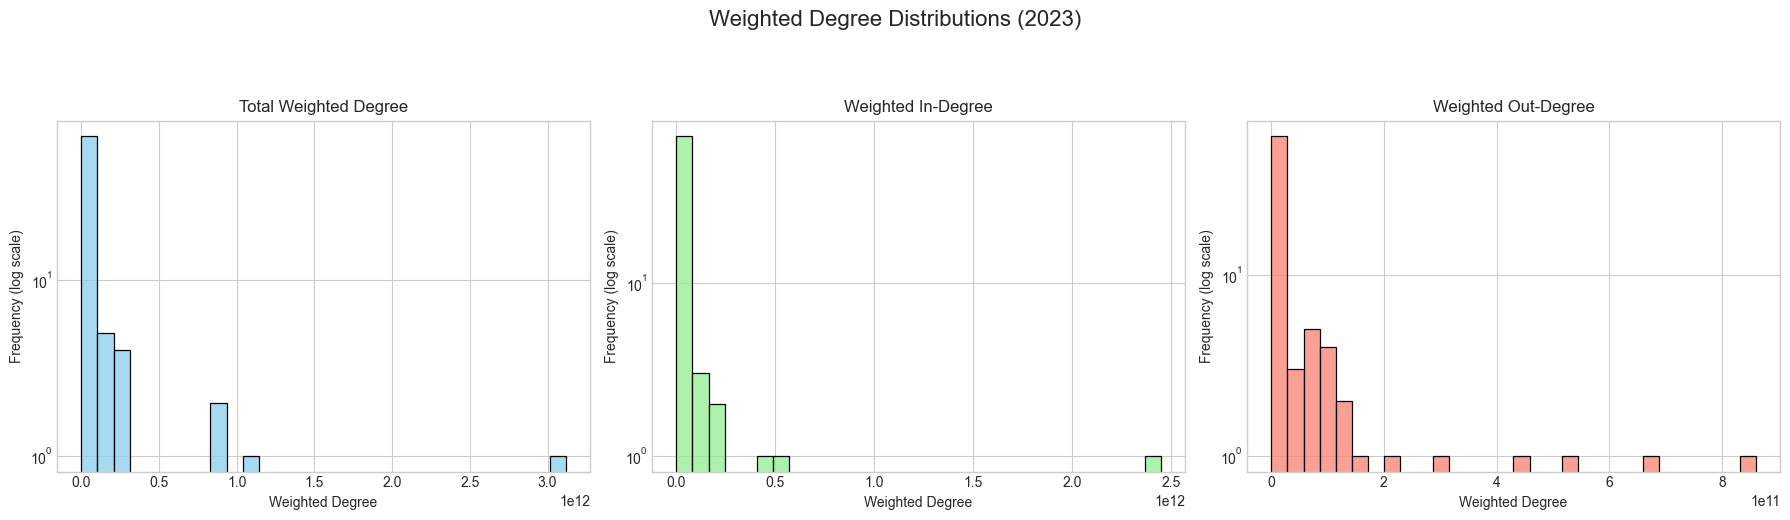


--- Power Law Fit Analysis (Weighted Degrees) ---
** Total Weighted Degree **
  Alpha (γ): 1.989
  xmin: 59030537377.255
  Kolmogorov-Smirnov (D): 0.0893
  vs Lognormal: R=0.052, p=0.9588 (Positive R favors power_law, p<0.1 is significant)


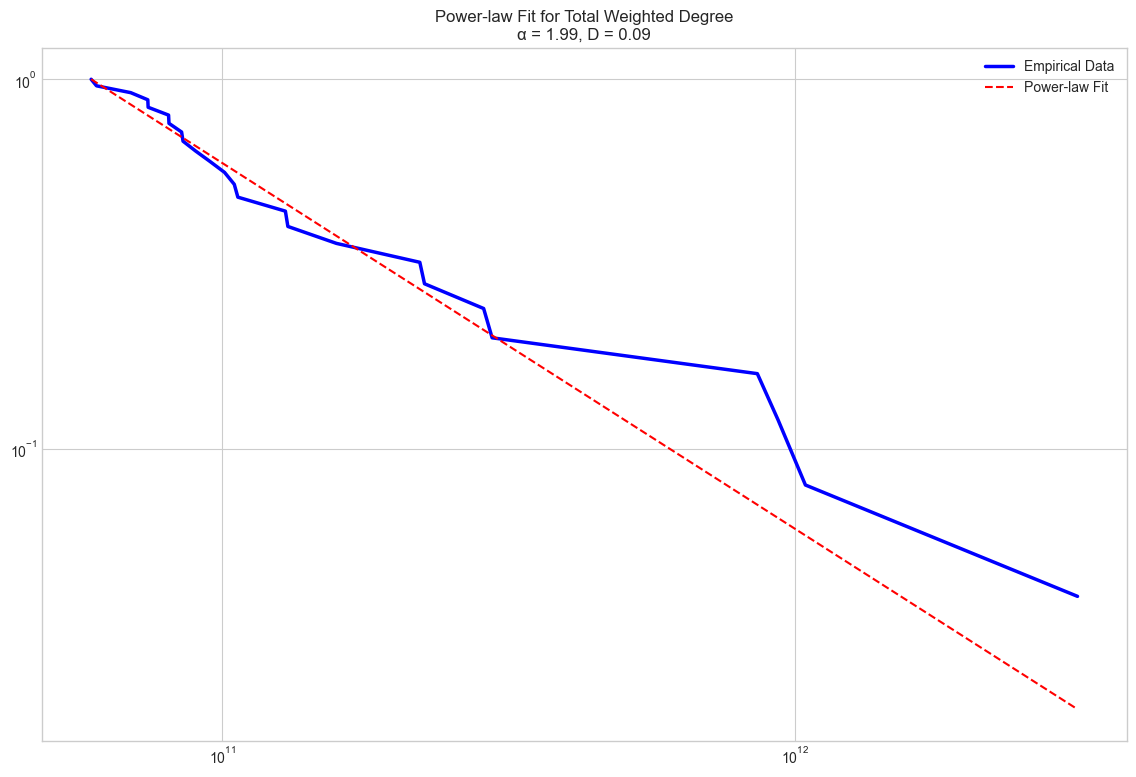

** Weighted In-Degree **
  Alpha (γ): 1.874
  xmin: 51519480995.690
  Kolmogorov-Smirnov (D): 0.1101
  vs Lognormal: R=-0.086, p=0.9315 (Positive R favors power_law, p<0.1 is significant)


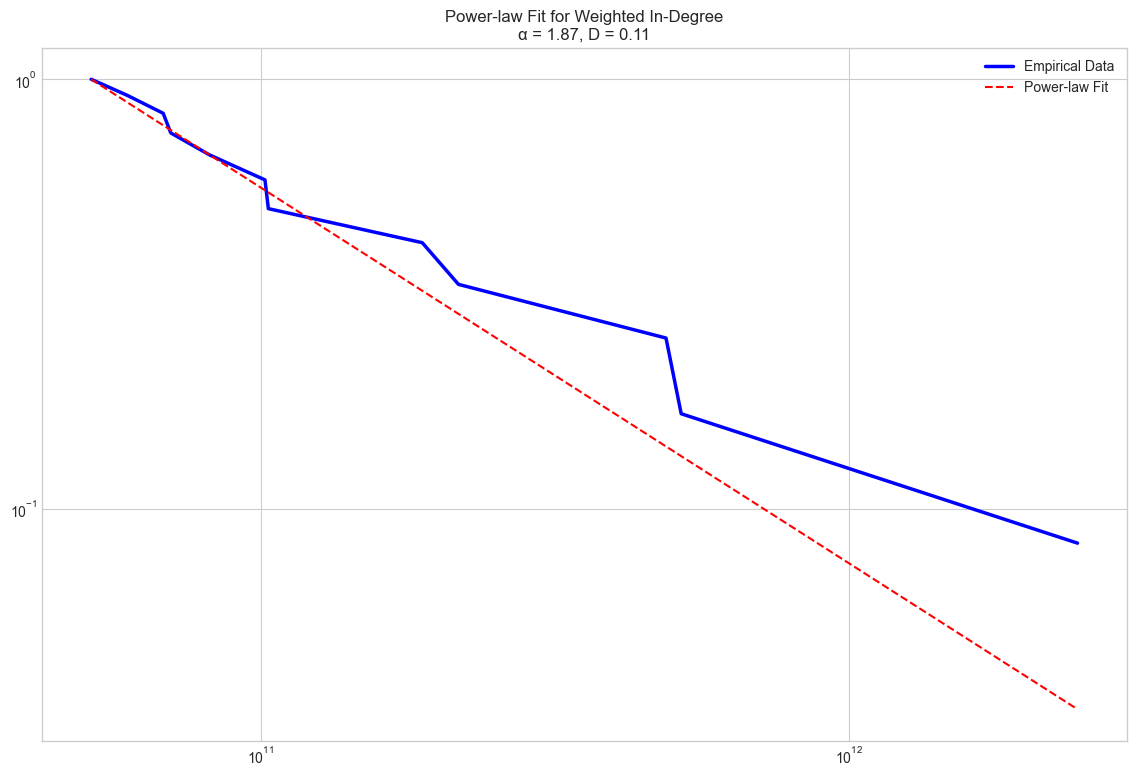

** Weighted Out-Degree **
  Alpha (γ): 2.021
  xmin: 59030537377.255
  Kolmogorov-Smirnov (D): 0.1069
  vs Lognormal: R=-0.524, p=0.6006 (Positive R favors power_law, p<0.1 is significant)


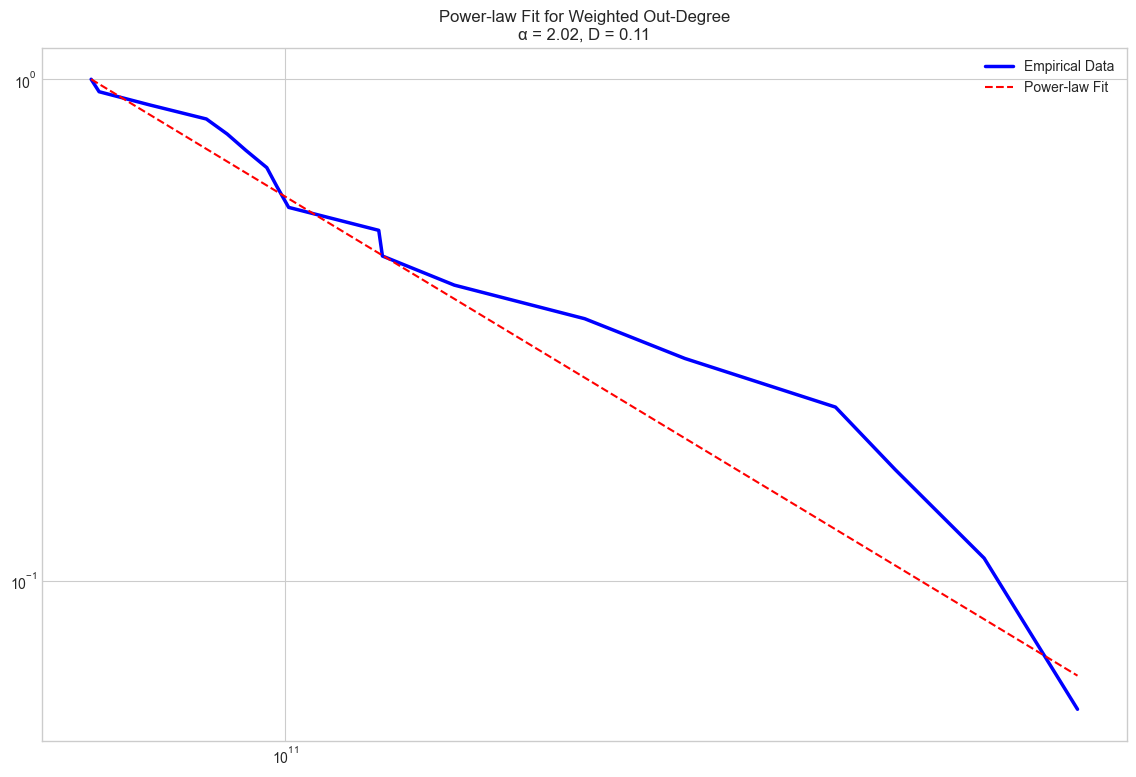


Degree Assortativity (unweighted, undirected): -0.1129


In [56]:
if G_2023.number_of_nodes() > 0:
    # --- Plot Degree Distributions ---
    degrees_w = [d for n,d in G_2023.degree(weight='weight')]
    in_degrees_w = [d for n,d in G_2023.in_degree(weight='weight')]
    out_degrees_w = [d for n,d in G_2023.out_degree(weight='weight')]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Weighted Degree Distributions ({STATIC_ANALYSIS_YEAR})', fontsize=16, y=1.03)
    
    titles = ['Total Weighted Degree', 'Weighted In-Degree', 'Weighted Out-Degree']
    datas = [degrees_w, in_degrees_w, out_degrees_w]
    colors = ['skyblue', 'lightgreen', 'salmon']
    
    for i, (data, title, color) in enumerate(zip(datas, titles, colors)):
        sns.histplot(data, bins=30, kde=False, ax=axs[i], color=color, log_scale=(False, True) if any(d > 0 for d in data) else False)
        axs[i].set_title(title)
        axs[i].set_xlabel('Weighted Degree')
        axs[i].set_ylabel('Frequency (log scale)')
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- Power Law Fit Analysis ---
    print("\n--- Power Law Fit Analysis (Weighted Degrees) ---")
    
    def analyze_pl_fit(data, name):
        """
        Fits a power-law distribution to the data and plots the result.
        """
        fdata = [d for d in data if d > 0]
        if len(fdata) < 10:
            print(f"Not enough data points for {name} to perform a reliable fit.")
            return
        
        try:
            # Fit the data. The library automatically finds the best xmin.
            fit = powerlaw.Fit(fdata, discrete=False, verbose=False)
            
            # Print the statistical results
            print(f"** {name} **")
            print(f"  Alpha (γ): {fit.power_law.alpha:.3f}")
            print(f"  xmin: {fit.power_law.xmin:.3f}")
            print(f"  Kolmogorov-Smirnov (D): {fit.power_law.D:.4f}")
            
            # Compare power-law to log-normal distribution
            R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
            print(f"  vs Lognormal: R={R_ln:.3f}, p={p_ln:.4f} (Positive R favors power_law, p<0.1 is significant)")

            # Plot the CCDF (Complementary Cumulative Distribution Function)
            fig_pl = fit.plot_ccdf(color='b', linewidth=2.5, label='Empirical Data')
            fit.power_law.plot_ccdf(ax=fig_pl, color='r', linestyle='--', label='Power-law Fit')
            
            title_str = (f'Power-law Fit for {name}\n'
                         f'α = {fit.power_law.alpha:.2f}, D = {fit.power_law.D:.2f}')
            plt.title(title_str)
            plt.legend()
            plt.show()
            
        except Exception as e:
            print(f"Error fitting {name}: {e}")

    analyze_pl_fit(degrees_w, 'Total Weighted Degree')
    analyze_pl_fit(in_degrees_w, 'Weighted In-Degree')
    analyze_pl_fit(out_degrees_w, 'Weighted Out-Degree')

    # --- Assortativity Calculation ---
    G_undir_assort = G_2023.to_undirected()
    if G_undir_assort.number_of_edges() > 0:
        assort = nx.degree_assortativity_coefficient(G_undir_assort)
        print(f"\nDegree Assortativity (unweighted, undirected): {assort:.4f}")
else:
    print("Graph empty, skipping degree distributions and power-law fits.")

## 11. Comparison with Standard Network Models (2023)
The properties of the real-world trade network are compared against three standard network models: Erdős-Rényi (ER), Barabási-Albert (BA), and Watts-Strogatz (WS). The real graph exhibits a significantly higher average clustering coefficient (**0.2934**) than the ER and BA models, and a much lower average path length (**2.4330**) than the WS model. This combination of high local clustering and short global paths is a hallmark of a "small-world" network, a common feature in many real-world social and economic systems.

In [57]:
model_comp_results = []
if G_2023.number_of_nodes() > 0:
    G_comp_base = G_2023.to_undirected()
    G_comp_base.remove_edges_from(nx.selfloop_edges(G_comp_base))
    for u,v,d in list(G_comp_base.edges(data=True)): # Make unweighted for model comparison
        if 'weight' in d: del G_comp_base[u][v]['weight']
    N_comp, M_comp = G_comp_base.number_of_nodes(), G_comp_base.number_of_edges()

    if N_comp > 0 and M_comp > 0:
        avg_clust_real = nx.average_clustering(G_comp_base)
        avg_path_real = float('nan')
        if nx.is_connected(G_comp_base): 
            avg_path_real = nx.average_shortest_path_length(G_comp_base)
        else: 
            if N_comp > 1: 
                lcc = G_comp_base.subgraph(max(nx.connected_components(G_comp_base), key=len))
                if lcc.number_of_nodes() > 1: 
                    avg_path_real = nx.average_shortest_path_length(lcc)
        model_comp_results.append({'Model':'Real Graph', 'Avg Clust':avg_clust_real, 'Avg Path':avg_path_real})
        k_avg_comp = 2 * M_comp / N_comp

        # ER Model
        if N_comp > 1: 
            p_er = max(0, min(1, k_avg_comp / (N_comp - 1)))
            G_er = nx.erdos_renyi_graph(N_comp, p_er, seed=42)
            avg_c_er = nx.average_clustering(G_er)
            avg_p_er = float('nan')
            if nx.is_connected(G_er) and N_comp > 1: 
                avg_p_er = nx.average_shortest_path_length(G_er)
            elif N_comp > 1: 
                lcc_er = G_er.subgraph(max(nx.connected_components(G_er), key=len))
                if lcc_er.number_of_nodes() > 1: 
                    avg_p_er = nx.average_shortest_path_length(lcc_er)
            model_comp_results.append({'Model':'ER', 'Avg Clust':avg_c_er, 'Avg Path':avg_p_er})
        
        # BA Model
        if N_comp > 1 and k_avg_comp > 0: 
            m_ba = max(1, int(round(k_avg_comp/2)))
            if m_ba < N_comp: 
                G_ba = nx.barabasi_albert_graph(N_comp, m_ba, seed=42)
                avg_c_ba = nx.average_clustering(G_ba)
                avg_p_ba = float('nan')
                if nx.is_connected(G_ba) and N_comp > 1: 
                    avg_p_ba = nx.average_shortest_path_length(G_ba)
                model_comp_results.append({'Model':'BA', 'Avg Clust':avg_c_ba, 'Avg Path':avg_p_ba})
        
        # WS Model
        if N_comp > 2 and k_avg_comp > 0:
            k_ws = max(2, int(round(k_avg_comp)) // 2 * 2) # Must be even and >=2
            if k_ws < N_comp and k_ws > 0:
                G_ws = nx.watts_strogatz_graph(N_comp, k_ws, 0.1, seed=42)
                avg_c_ws = nx.average_clustering(G_ws)
                avg_p_ws = float('nan')
                if nx.is_connected(G_ws) and N_comp > 1: 
                    avg_p_ws = nx.average_shortest_path_length(G_ws)
                elif N_comp > 1: 
                    lcc_ws = G_ws.subgraph(max(nx.connected_components(G_ws), key=len))
                    if lcc_ws.number_of_nodes() > 1: 
                        avg_p_ws = nx.average_shortest_path_length(lcc_ws)
                model_comp_results.append({'Model':'WS', 'Avg Clust':avg_c_ws, 'Avg Path':avg_p_ws})

        df_model_comp_final = pd.DataFrame(model_comp_results)
        print("\n--- Network Model Comparison Summary ---")
        display(HTML(df_model_comp_final.to_html(index=False, float_format="%.4f")))
    else: 
        print("Skipping model comparison: Graph has no edges or too few nodes after unweighting.")
else: 
    print("Skipping model comparison: Initial graph empty.")


--- Network Model Comparison Summary ---


Model,Avg Clust,Avg Path
Real Graph,0.2934,2.4330
ER,0.1372,2.0312
BA,0.2618,2.0058
WS,0.5018,2.5372


## 12. Part 3 Conclusion
This part provided a comprehensive static analysis of the global trade network for the year 2023. Key findings include the identification of dominant trade hubs, the confirmation of the network's 'small-world' properties (Avg Clustering: **0.2934**, Avg Path Length: **2.4330**), and the successful detection of meaningful trade communities using the **Greedy Modularity** algorithm, which found 4 communities with a modularity of **0.1094**. The insights gained from this static snapshot serve as a valuable baseline for understanding the more complex, dynamic analyses in subsequent parts of the project.

In [58]:
if 'df_model_comp_final' in locals() and not df_model_comp_final.empty:
    real_props = df_model_comp_final[df_model_comp_final['Model'] == 'Real Graph']
    if not real_props.empty:
        print(f"\nSummary for Real Graph ({STATIC_ANALYSIS_YEAR}): Avg Clustering = {real_props['Avg Clust'].iloc[0]:.4f}, Avg Path Length = {real_props['Avg Path'].iloc[0]:.4f}")
        # Further interpretation on small-world properties can be added here by comparing to ER/WS values.
if 'best_community_result' in locals() and best_community_result:
    print(f"Best community detection by {best_community_result.get('Algorithm', 'N/A')}: {best_community_result.get('Num Communities', 'N/A')} communities, Modularity: {best_community_result.get('Modularity', 0.0):.4f}.")


Summary for Real Graph (2023): Avg Clustering = 0.2934, Avg Path Length = 2.4330
Best community detection by Greedy Modularity: 4 communities, Modularity: 0.1094.


This comprehensive analysis of the 2023 static network has successfully fulfilled the following key objectives:
- Loaded and filtered data for the snapshot year.
- Conducted EDA to identify top importers/exporters and analyze the trade amount distribution.
- Constructed and characterized the 2023 trade graph, detailing its properties, degree distributions, and assortativity.
- Identified key countries using multiple centrality measures and a composite score.
- Performed community detection with several algorithms, including Spectral Clustering, and compared results with a ground truth.
- Visualized the network, centralities, and communities on world maps.
- Analyzed k-cores and maximal cliques for deeper structural insights.
- Investigated power-law characteristics of the network's degree distributions.
- Compared the real network's properties to standard random graph models to establish its small-world nature.